# *Quick, Draw!* GAN

In this notebook, we use Generative Adversarial Network code (adapted from [Rowel Atienza's](https://github.com/roatienza/Deep-Learning-Experiments/blob/master/Experiments/Tensorflow/GAN/dcgan_mnist.py) under [MIT License](https://github.com/roatienza/Deep-Learning-Experiments/blob/master/LICENSE)) to create sketches in the style of humans who have played the [*Quick, Draw!* game](https://quickdraw.withgoogle.com) (data available [here](https://github.com/googlecreativelab/quickdraw-dataset) under [Creative Commons Attribution 4.0 license](https://creativecommons.org/licenses/by/4.0/)).

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/the-deep-learners/deep-learning-illustrated/blob/master/notebooks/generative_adversarial_network.ipynb)

_In order to efficiently carry out the training in this notebook, we recommend using a GPU. Most readers don't have a GPU suitable for TensorFlow operations (i.e., an Nvidia GPU with CUDA and cuDNN drivers installed) available on their local machine, however you can easily access one for free via [Colab](https://colab.research.google.com/)._ 

_Separately, for reasons that escape us, the discriminator in this notebook nearly always fails to learn if you train on a CPU only. Because of this failure, the GAN will seldom learn how to generate sketches -- i.e., it will output images that are merely random noise. There are two ways we've identified to remedy this situation:_ 

1. _**Use a GPU.** If you don't have one, use Colab as suggested above. While in Colab, you can select "Change runtime type" from the "Runtime" item in the menu bar, and choose "GPU" as your hardware accelerator. This hardware accelerator trains the GAN orders of magnitude more rapidly than the "None" or "TPU" options, and the discriminator (we have no idea why!) will train properly._
2. _**Change the discriminator's optimizer.** As noted by a comment in this notebook's discriminator compilation step, switching from the default RMSprop optimizer to another (e.g., Adam or AdaDelta) enables the discriminator to learn effectively and therefore the GAN generates sketches. Whether you use a CPU only, a GPU, or a TPU, this solution is effective. (That said, training the GAN with a GPU is still way faster than with a CPU only or a TPU.)_

#### Load dependencies

In [1]:
# for data input and output:
import numpy as np
import os

# for deep learning: 
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, Dropout
from keras.layers import BatchNormalization, Flatten
from keras.layers import Activation
from keras.layers import Reshape # new! 
from keras.layers import Conv2DTranspose, UpSampling2D # new! 
from keras.optimizers import RMSprop # new! 

# for plotting: 
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

Using TensorFlow backend.


#### Load data
NumPy bitmap files are [here](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap) -- pick your own drawing category -- you don't have to pick *apples* :)

_If you're using Colab, the easiest way to load the data is to access it from Google Drive (detailed instructions are provided [here](https://colab.research.google.com/notebooks/io.ipynb#scrollTo=u22w3BFiOveA))._

*For example, after we downloaded the "apple.npy" file, we placed it in our personal Google Drive in a subdirectory called "quickdraw_data" within a directory called "Colab Notebooks" (Colab creates this directory for saving notebooks by default). [Here's a screenshot](https://github.com/the-deep-learners/deep-learning-illustrated/blob/master/img/apples-in-drive.png) of what that looks like in the Google Drive web-browser interface. The data in place, we then ran the following (commented out) commands before executing the remainder of the notebook:*

In [ ]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# os.chdir('/content/gdrive/My Drive/Colab Notebooks/quickdraw_data')

In [2]:
input_images = "../quickdraw_data/apple.npy"

In [3]:
data = np.load(input_images) # 28x28 (sound familiar?) grayscale bitmap in numpy .npy format; images are centered

In [4]:
data.shape

(144722, 784)

In [5]:
data[4242]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,  36,  79,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0, 134, 238,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0, 119, 254,   4,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0, 101, 255,  21,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,  82, 255,  39,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   

In [6]:
data = data/255
data = np.reshape(data,(data.shape[0],28,28,1)) # fourth dimension is color
img_w,img_h = data.shape[1:3]
data.shape

(144722, 28, 28, 1)

In [7]:
data[4242]

array([[[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ]],

       [[ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.        ],
        [ 0.14117647],
        [ 0.30980392],
        [

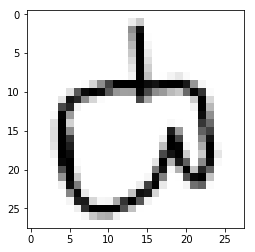

In [8]:
plt.imshow(data[4242,:,:,0], cmap='Greys')

#### Create discriminator network

In [9]:
def build_discriminator(depth=64, p=0.4):

    # Define inputs
    image = Input((img_w,img_h,1))
    
    # Convolutional layers
    conv1 = Conv2D(depth*1, 5, strides=2, 
                   padding='same', activation='relu')(image)
    conv1 = Dropout(p)(conv1)
    
    conv2 = Conv2D(depth*2, 5, strides=2, 
                   padding='same', activation='relu')(conv1)
    conv2 = Dropout(p)(conv2)
    
    conv3 = Conv2D(depth*4, 5, strides=2, 
                   padding='same', activation='relu')(conv2)
    conv3 = Dropout(p)(conv3)
    
    conv4 = Conv2D(depth*8, 5, strides=1, 
                   padding='same', activation='relu')(conv3)
    conv4 = Flatten()(Dropout(p)(conv4))
    
    # Output layer
    prediction = Dense(1, activation='sigmoid')(conv4)
    
    # Model definition
    model = Model(inputs=image, outputs=prediction)
    
    return model

In [10]:
discriminator = build_discriminator()

In [11]:
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 4, 256)         0         
__________

In [12]:
discriminator.compile(loss='binary_crossentropy', 
                      optimizer=RMSprop(lr=0.0008, 
                                        decay=6e-8, 
                                        clipvalue=1.0), 
                      metrics=['accuracy'])

_N.B.: Bizarrely, if you're using a CPU only to train your model (i.e., you're not using a GPU), then the RMSprop optimizer nearly always fails to train the discriminator. Instead of compiling the discriminator with RMSprop you could compile it with AdaGrad or Adam, as in the following (commented out) cell block._

In [ ]:
# from keras.optimizers import Adam 
# discriminator.compile(loss='binary_crossentropy', 
#                       optimizer=Adam(lr=0.0008, 
#                                      clipvalue=1.0), 
#                       metrics=['accuracy'])

#### Create generator network

In [13]:
z_dimensions = 32

In [14]:
def build_generator(latent_dim=z_dimensions, 
                    depth=64, p=0.4):
    
    # Define inputs
    noise = Input((latent_dim,))
    
    # First dense layer
    dense1 = Dense(7*7*depth)(noise)
    dense1 = BatchNormalization(momentum=0.9)(dense1) # default momentum for moving average is 0.99
    dense1 = Activation(activation='relu')(dense1)
    dense1 = Reshape((7,7,depth))(dense1)
    dense1 = Dropout(p)(dense1)
    
    # De-Convolutional layers
    conv1 = UpSampling2D()(dense1)
    conv1 = Conv2DTranspose(int(depth/2), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv1)
    conv1 = BatchNormalization(momentum=0.9)(conv1)
    conv1 = Activation(activation='relu')(conv1)
    
    conv2 = UpSampling2D()(conv1)
    conv2 = Conv2DTranspose(int(depth/4), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv2 = BatchNormalization(momentum=0.9)(conv2)
    conv2 = Activation(activation='relu')(conv2)
    
    conv3 = Conv2DTranspose(int(depth/8), 
                            kernel_size=5, padding='same', 
                            activation=None,)(conv2)
    conv3 = BatchNormalization(momentum=0.9)(conv3)
    conv3 = Activation(activation='relu')(conv3)

    # Output layer
    image = Conv2D(1, kernel_size=5, padding='same', 
                   activation='sigmoid')(conv3)

    # Model definition    
    model = Model(inputs=noise, outputs=image)
    
    return model

In [15]:
generator = build_generator()

In [16]:
generator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3136)              103488    
_________________________________________________________________
batch_normalization_1 (Batch (None, 3136)              12544     
_________________________________________________________________
activation_1 (Activation)    (None, 3136)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 64)        0         
__________

#### Create adversarial network

In [17]:
z = Input(shape=(z_dimensions,))
img = generator(z)

In [18]:
discriminator.trainable = False

In [19]:
pred = discriminator(img)

In [20]:
adversarial_model = Model(z, pred)

In [21]:
adversarial_model.compile(loss='binary_crossentropy', 
                          optimizer=RMSprop(lr=0.0004, 
                                            decay=3e-8, 
                                            clipvalue=1.0), 
                          metrics=['accuracy'])

#### Train!

In [22]:
def train(epochs=2000, batch=128, z_dim=z_dimensions):
    
    d_metrics = []
    a_metrics = []
    
    running_d_loss = 0
    running_d_acc = 0
    running_a_loss = 0
    running_a_acc = 0
    
    for i in range(epochs):
        
        # sample real images: 
        real_imgs = np.reshape(
            data[np.random.choice(data.shape[0],
                                  batch,
                                  replace=False)],
            (batch,28,28,1))
        
        # generate fake images: 
        fake_imgs = generator.predict(
            np.random.uniform(-1.0, 1.0, 
                              size=[batch, z_dim]))
        
        # concatenate images as discriminator inputs:
        x = np.concatenate((real_imgs,fake_imgs))
        
        # assign y labels for discriminator: 
        y = np.ones([2*batch,1])
        y[batch:,:] = 0
        
        # train discriminator: 
        d_metrics.append(
            discriminator.train_on_batch(x,y)
        )
        running_d_loss += d_metrics[-1][0]
        running_d_acc += d_metrics[-1][1]
        
        # adversarial net's noise input and "real" y: 
        noise = np.random.uniform(-1.0, 1.0, 
                                  size=[batch, z_dim])
        y = np.ones([batch,1])
        
        # train adversarial net: 
        a_metrics.append(
            adversarial_model.train_on_batch(noise,y)
        ) 
        running_a_loss += a_metrics[-1][0]
        running_a_acc += a_metrics[-1][1]
        
        # periodically print progress & fake images: 
        if (i+1)%100 == 0:

            print('Epoch #{}'.format(i))
            log_mesg = "%d: [D loss: %f, acc: %f]" % \
            (i, running_d_loss/i, running_d_acc/i)
            log_mesg = "%s  [A loss: %f, acc: %f]" % \
            (log_mesg, running_a_loss/i, running_a_acc/i)
            print(log_mesg)

            noise = np.random.uniform(-1.0, 1.0, 
                                      size=[16, z_dim])
            gen_imgs = generator.predict(noise)

            plt.figure(figsize=(5,5))

            for k in range(gen_imgs.shape[0]):
                plt.subplot(4, 4, k+1)
                plt.imshow(gen_imgs[k, :, :, 0], 
                           cmap='gray')
                plt.axis('off')
                
            plt.tight_layout()
            plt.show()
    
    return a_metrics, d_metrics

_N.B.: Running the next cell leads to the following warning in recent versions of Keras:_

Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?

_This warning can be safely ignored. In most neural networks, you should indeed ensure that you compile the model after adjusting whether the models weights are trainable or not. In a GAN, however, this is unnecessary: The discriminator need not be compiled after making its weights untrainable; instead, we compile these untrainable weights as a part of the adversarial model. You can read more about this unnecessary warning [here](https://github.com/keras-team/keras/issues/8585) and [here](https://github.com/tensorflow/tensorflow/issues/22012). If the warning **really** bothers you though, we created a GAN notebook with an awkward workaround [here](https://github.com/the-deep-learners/deep-learning-illustrated/blob/master/notebooks/awkward-GAN-with-no-warning.ipynb)._

Epoch #99
99: [D loss: 0.308268, acc: 0.938605]  [A loss: 3.351842, acc: 0.289694]


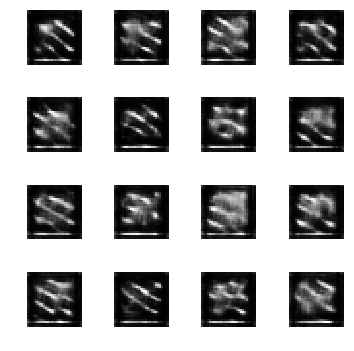

Epoch #199
199: [D loss: 0.294289, acc: 0.928765]  [A loss: 3.554233, acc: 0.174545]


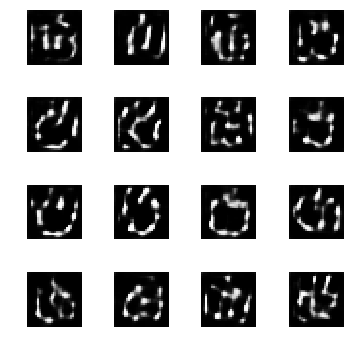

Epoch #299
299: [D loss: 0.333603, acc: 0.898411]  [A loss: 3.123141, acc: 0.154473]


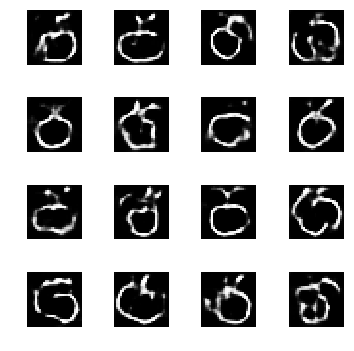

Epoch #399
399: [D loss: 0.368001, acc: 0.870262]  [A loss: 2.777383, acc: 0.156505]


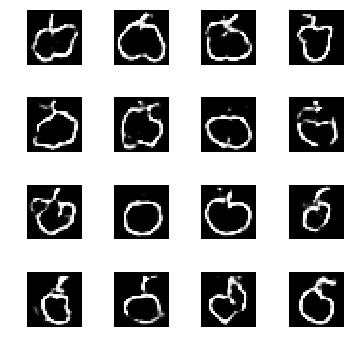

Epoch #499
499: [D loss: 0.390248, acc: 0.849731]  [A loss: 2.572680, acc: 0.156688]


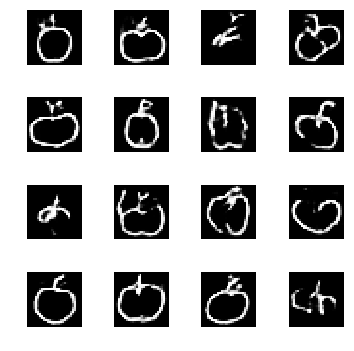

Epoch #599
599: [D loss: 0.404920, acc: 0.837522]  [A loss: 2.442488, acc: 0.155559]


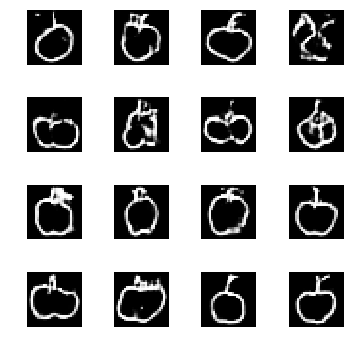

Epoch #699
699: [D loss: 0.410297, acc: 0.831282]  [A loss: 2.377832, acc: 0.153791]


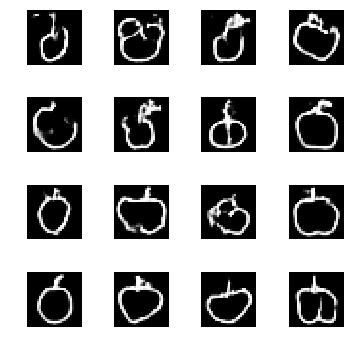

Epoch #799
799: [D loss: 0.412047, acc: 0.827812]  [A loss: 2.342445, acc: 0.152476]


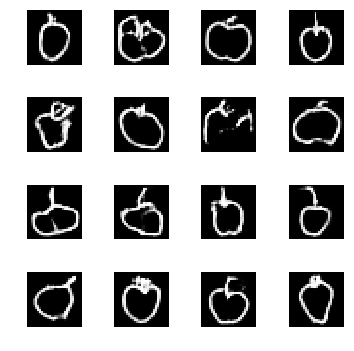

Epoch #899
899: [D loss: 0.412766, acc: 0.825488]  [A loss: 2.326389, acc: 0.150697]


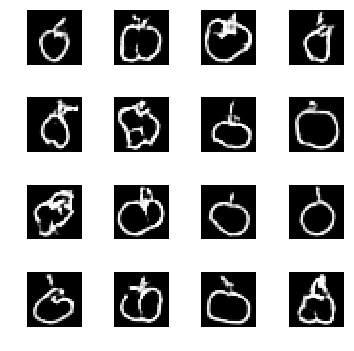

Epoch #999
999: [D loss: 0.412487, acc: 0.824074]  [A loss: 2.315010, acc: 0.149032]


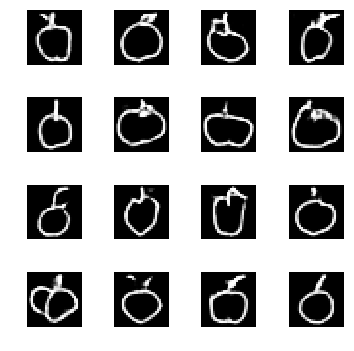

Epoch #1099
1099: [D loss: 0.410315, acc: 0.824109]  [A loss: 2.323983, acc: 0.146461]


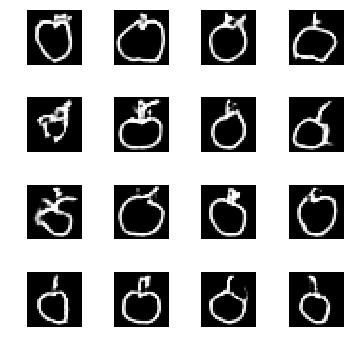

Epoch #1199
1199: [D loss: 0.407442, acc: 0.824668]  [A loss: 2.340701, acc: 0.144691]


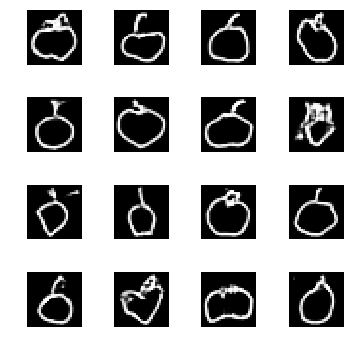

Epoch #1299
1299: [D loss: 0.404047, acc: 0.825867]  [A loss: 2.361092, acc: 0.142622]


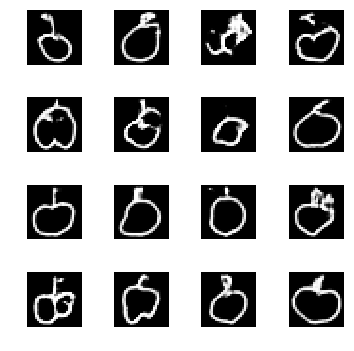

Epoch #1399
1399: [D loss: 0.400849, acc: 0.827095]  [A loss: 2.380299, acc: 0.140815]


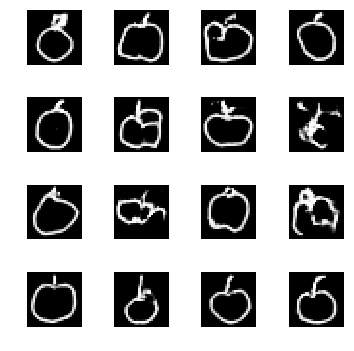

Epoch #1499
1499: [D loss: 0.397709, acc: 0.828391]  [A loss: 2.400541, acc: 0.138613]


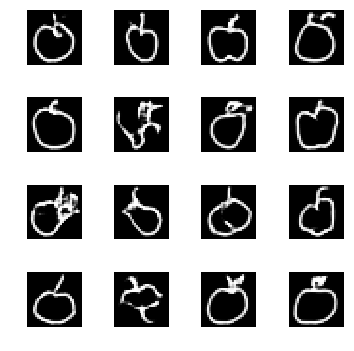

Epoch #1599
1599: [D loss: 0.394321, acc: 0.829828]  [A loss: 2.426607, acc: 0.136487]


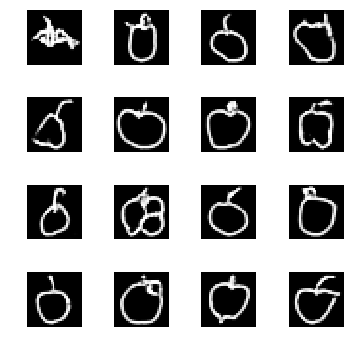

Epoch #1699
1699: [D loss: 0.390676, acc: 0.831433]  [A loss: 2.448597, acc: 0.134541]


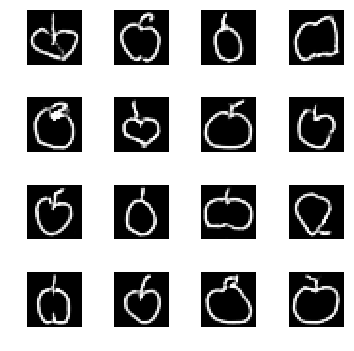

Epoch #1799
1799: [D loss: 0.387178, acc: 0.832885]  [A loss: 2.474159, acc: 0.132565]


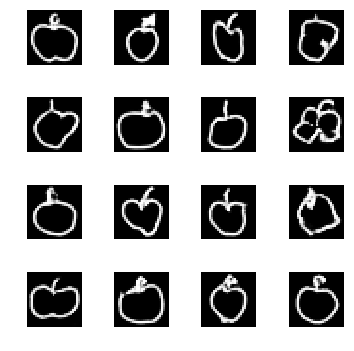

Epoch #1899
1899: [D loss: 0.384078, acc: 0.834123]  [A loss: 2.497276, acc: 0.130850]


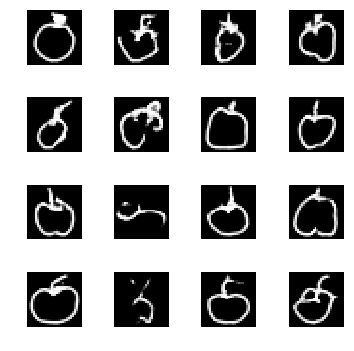

Epoch #1999
1999: [D loss: 0.380695, acc: 0.835586]  [A loss: 2.522729, acc: 0.129014]


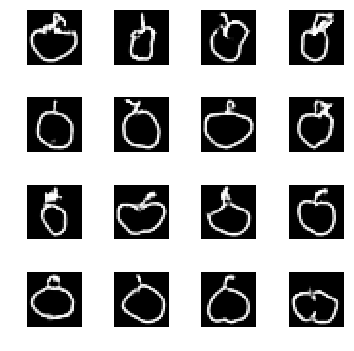

In [23]:
a_metrics_complete, d_metrics_complete = train()

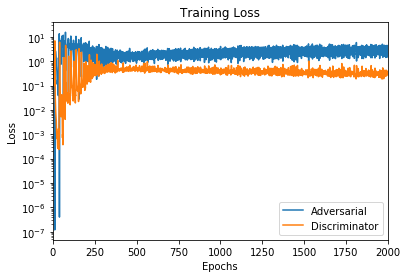

In [24]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[0] for metric in a_metrics_complete],
        'Discriminator': [metric[0] for metric in d_metrics_complete],
    }
).plot(title='Training Loss', logy=True)
ax.set_xlabel("Epochs")
ax.set_ylabel("Loss")

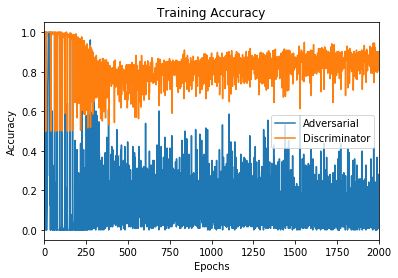

In [25]:
ax = pd.DataFrame(
    {
        'Adversarial': [metric[1] for metric in a_metrics_complete],
        'Discriminator': [metric[1] for metric in d_metrics_complete],
    }
).plot(title='Training Accuracy')
ax.set_xlabel("Epochs")
ax.set_ylabel("Accuracy")